In [95]:
import yfinance as yf
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
#import matplotlib.pyplot as plt

import numpy as np

class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = len(X), len(X[0])
        self.weights = [0] * num_features
        self.bias = 0

        for _ in range(self.num_iterations):
            linear_model = [sum(X[i][j] * self.weights[j] for j in range(num_features)) + self.bias for i in range(num_samples)]
            y_pred = [self.sigmoid(value) for value in linear_model]
            dw = [sum(X[i][j] * (y_pred[i] - y[i]) for i in range(num_samples)) for j in range(num_features)]
            db = sum(y_pred[i] - y[i] for i in range(num_samples))
            self.weights = [self.weights[j] - self.learning_rate * dw[j] for j in range(num_features)]
            self.bias -= self.learning_rate * db

    def predict(self, X):
        num_samples, num_features = len(X), len(X[0])
        linear_model = [sum(X[i][j] * self.weights[j] for j in range(num_features)) + self.bias for i in range(num_samples)]
        y_pred = [self.sigmoid(value) for value in linear_model]
        return [1 if p >= 0.5 else 0 for p in y_pred]
    
    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return sum(1 for p, t in zip(y_pred, y) if p == t) / len(y)
    
    def f1_score(self, X, y):
        tp = sum(1 for p, t in zip(self.predict(X), y) if p == 1 and t == 1)
        fp = sum(1 for p, t in zip(self.predict(X), y) if p == 1 and t == 0)
        fn = sum(1 for p, t in zip(self.predict(X), y) if p == 0 and t == 1)
    
        # Check if there are any true positives to avoid division by zero
        if tp == 0:
            return 0
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        return 2 * (precision * recall) / (precision + recall)



def get_stock_data(symbol, start, end):
    data = yf.download(tickers=symbol, start=start, end=end)
    return data


I had to use python library functions here as I was encountering data compatability issues when using simple logical and arethemetic operators.  

In [96]:

def calculate_technical_indicators(data):
    # Simple Moving Averages (SMA)
    data['SMA 30'] = data['Close'].rolling(window=30).mean()
    data['SMA 100'] = data['Close'].rolling(window=100).mean()

    # Exponential Moving Averages (EMA)
    data['EMA 12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA 26'] = data['Close'].ewm(span=26, adjust=False).mean()

    # MACD Line
    data['MACD Line'] = data['EMA 12'] - data['EMA 26']

    # Signal Line
    data['Signal Line'] = data['MACD Line'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands (BB)
    data['20 Day MA'] = data['Close'].rolling(window=20).mean()
    data['20 Day STD'] = data['Close'].rolling(window=20).std()
    data['Upper Band'] = data['20 Day MA'] + (data['20 Day STD'] * 2)
    data['Lower Band'] = data['20 Day MA'] - (data['20 Day STD'] * 2)

    # Standard Deviation (STD)
    data['STD'] = data['Close'].rolling(window=20).std()

    return data


The signals were to be generated using a weighted average system, but the weights of each indicator are based on the significance of the indicator rather than statistic data.  

In [97]:

def generate_signals(data, weights):
    signals = []
    for i in range(len(data)):
        sma_condition = data['Close'][i] > data['SMA 30'][i] and data['Close'][i] > data['SMA 100'][i]
        ema_condition = data['EMA 12'][i] > data['EMA 26'][i]
        macd_condition = data['MACD Line'][i] > data['Signal Line'][i]
        bb_condition = data['Close'][i] < data['Lower Band'][i]

        weighted_avg = (
            weights['SMA'] * sma_condition +
            weights['EMA'] * ema_condition +
            weights['MACD'] * macd_condition +
            weights['BB'] * bb_condition
        )

        if weighted_avg >= 0.5:
            signals.append('Buy')
        else:
            signals.append('Sell')
    
    data['Signal'] = signals
    return data




The above cells consist of all the functions used in determining the signals and logistic regression accuracy

In [98]:
data

,Open,High,Low,Close,Adj Close,Volume,SMA 30,SMA 100,EMA 12,EMA 26,MACD Line,Signal Line,20 Day MA,20 Day STD,Upper Band,Lower Band,STD,Signal
Date,,,,,,,,,,,,,,,,,,
2019-01-01,173.500000,174.199997,171.300003,173.449997,172.911087,6715543,NaN,NaN,173.449997,173.449997,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-02,170.600006,171.750000,168.000000,168.550003,168.026321,13410104,NaN,NaN,172.696152,173.087034,-0.390883,-0.078177,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-03,169.000000,170.149994,165.100006,166.050003,165.534088,9321842,NaN,NaN,171.673667,172.565773,-0.892106,-0.240962,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-04,169.000000,171.949997,168.500000,170.949997,170.418854,17650435,NaN,NaN,171.562333,172.446086,-0.883752,-0.369520,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-07,173.199997,178.199997,173.199997,175.350006,174.805191,21438351,NaN,NaN,172.145052,172.661191,-0.516139,-0.398844,NaN,NaN,NaN,NaN,NaN,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,968.549988,970.599976,951.599976,957.750000,957.750000,9483750,955.705001,800.444000,975.343716,955.342655,20.001061,29.242210,971.497507,36.142363,1043.782232,899.212781,36.142363,Buy
2024-03-20,960.900024,965.150024,921.200012,940.450012,940.450012,13900321,955.735002,803.375001,969.975454,954.239496,15.735958,26.540959,972.202509,35.344056,1042.890621,901.514396,35.344056,Sell
2024-03-21,951.000000,969.250000,946.000000,964.900024,964.900024,11074207,956.771670,806.645501,969.194618,955.029165,14.165454,24.065858,974.395010,33.305167,1041.005344,907.784677,33.305167,Buy


Main() Function body starts here

In [99]:
symbol = 'TATAMOTORS.NS'
start_date = date(2019, 1, 1)
end_date = date.today()

# Get stock data

data = get_stock_data(symbol, start_date, end_date)

# Calculate technical indicators
data = calculate_technical_indicators(data)

# Taking Weighted average, but due to first time taking up this technique, I'm still learning how to determine weightage
# Assumed weights
weights = {'SMA': 0.20, 'EMA': 0.20, 'MACD': 0.50, 'BB': 0.10}

# Generate signals
data = generate_signals(data, weights)

# Prepare features and target
X = [[data['SMA 30'][i], data['SMA 100'][i], data['EMA 12'][i], data['EMA 26'][i], data['MACD Line'][i],
      data['Signal Line'][i], data['Upper Band'][i], data['Lower Band'][i]] for i in range(len(data))]
y = [1 if data['Signal'][i] == 'Buy' else 0 for i in range(len(data['Signal']))]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model accuracy
accuracy = model.accuracy(X_test, y_test)
print("Model Accuracy:", accuracy)

# Print F1 score
f1 = model.f1_score(X_test, y_test)
print("F1 Score:", f1)


[*********************100%%**********************]  1 of 1 completed
C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sma_condition = data['Close'][i] > data['SMA 30'][i] and data['Close'][i] > data['SMA 100'][i]
C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_condition = data['EMA 12'][i] > data['EMA 26'][i]
C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

Model Accuracy: 0.5057915057915058
F1 Score: 0


In [100]:
#testing with different weights
weights = {'SMA': 0.25, 'EMA': 0.25, 'MACD': 0.25, 'BB': 0.25}

# Generate signals
data = generate_signals(data, weights)

# Prepare features and target
X = [[data['SMA 30'][i], data['SMA 100'][i], data['EMA 12'][i], data['EMA 26'][i], data['MACD Line'][i],
      data['Signal Line'][i], data['Upper Band'][i], data['Lower Band'][i]] for i in range(len(data))]
y = [1 if data['Signal'][i] == 'Buy' else 0 for i in range(len(data['Signal']))]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(learning_rate=0.01, num_iterations=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model accuracy
accuracy = model.accuracy(X_test, y_test)
print("Model Accuracy:", accuracy)

# Print F1 score
f1 = model.f1_score(X_test, y_test)
print("F1 Score:", f1)

C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sma_condition = data['Close'][i] > data['SMA 30'][i] and data['Close'][i] > data['SMA 100'][i]
C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema_condition = data['EMA 12'][i] > data['EMA 26'][i]
C:\Users\mypc\AppData\Local\Temp\ipykernel_1808\4043734951.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

Model Accuracy: 0.43243243243243246
F1 Score: 0


In [101]:
data

,Open,High,Low,Close,Adj Close,Volume,SMA 30,SMA 100,EMA 12,EMA 26,MACD Line,Signal Line,20 Day MA,20 Day STD,Upper Band,Lower Band,STD,Signal
Date,,,,,,,,,,,,,,,,,,
2019-01-01,173.500000,174.199997,171.300003,173.449997,172.911087,6715543,NaN,NaN,173.449997,173.449997,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-02,170.600006,171.750000,168.000000,168.550003,168.026321,13410104,NaN,NaN,172.696152,173.087034,-0.390883,-0.078177,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-03,169.000000,170.149994,165.100006,166.050003,165.534088,9321842,NaN,NaN,171.673667,172.565773,-0.892106,-0.240962,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-04,169.000000,171.949997,168.500000,170.949997,170.418854,17650435,NaN,NaN,171.562333,172.446086,-0.883752,-0.369520,NaN,NaN,NaN,NaN,NaN,Sell
2019-01-07,173.199997,178.199997,173.199997,175.350006,174.805191,21438351,NaN,NaN,172.145052,172.661191,-0.516139,-0.398844,NaN,NaN,NaN,NaN,NaN,Sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19,968.549988,970.599976,951.599976,957.750000,957.750000,9483750,955.705001,800.444000,975.343716,955.342655,20.001061,29.242210,971.497507,36.142363,1043.782232,899.212781,36.142363,Buy
2024-03-20,960.900024,965.150024,921.200012,940.450012,940.450012,13900321,955.735002,803.375001,969.975454,954.239496,15.735958,26.540959,972.202509,35.344056,1042.890621,901.514396,35.344056,Sell
2024-03-21,951.000000,969.250000,946.000000,964.900024,964.900024,11074207,956.771670,806.645501,969.194618,955.029165,14.165454,24.065858,974.395010,33.305167,1041.005344,907.784677,33.305167,Buy


[*********************100%%**********************]  1 of 1 completed

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-31,505.000000,520.000000,498.200012,517.750000,516.141357,27306578
2022-02-01,508.000000,514.750000,493.000000,504.299988,502.733124,48030231
2022-02-02,508.600006,514.450012,505.149994,506.399994,504.826599,14311040
2022-02-03,509.100006,514.299988,502.850006,504.500000,502.932526,15249245
2022-02-04,503.799988,507.799988,499.000000,500.600006,499.044647,12663199


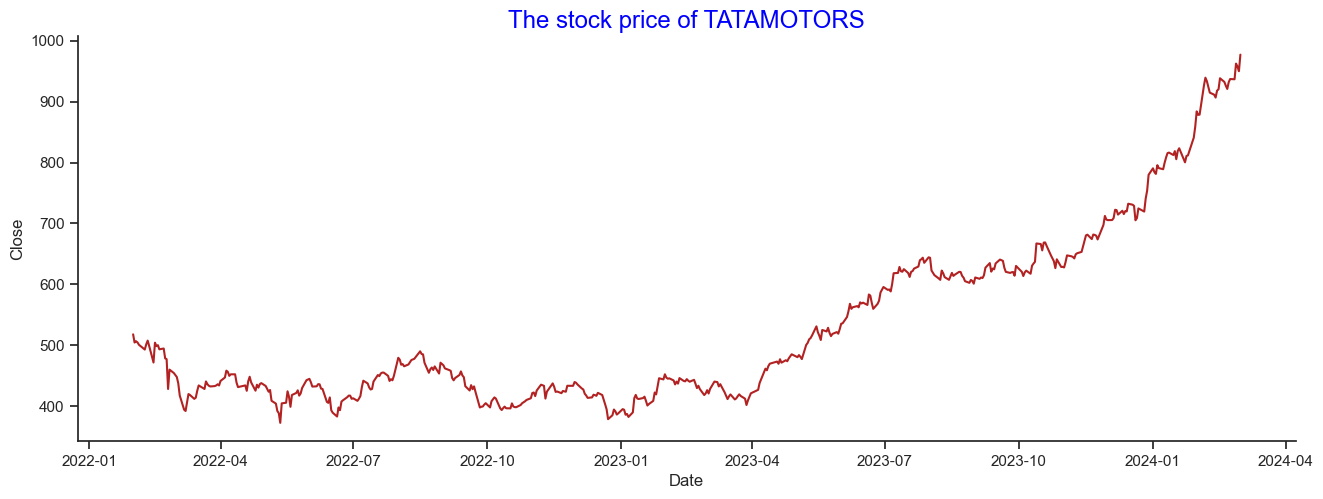

In [102]:
from datetime import date as date
#from monthdelta import monthdelta
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sea; sea.set()



def ma(Data, period, a):
    for i in range(len(Data)):
        if i < period:
            continue
        sum = 0
        for j in range(period):
            sum += Data[i - j]
        moving_average = sum / period
        print(moving_average)
        a[i]=moving_average
        #return moving_average
    

start_date = '2022-1-30'
end_date = '2024-3-2'

mns = yf.download(tickers="TATAMOTORS.NS", start = start_date, end = end_date)
ma_mns = [0]*len(mns['Close'])

ma(Data=mns["Close"], period=len(mns["Close"]), a=ma_mns)

#mns.head()
ind = [0]*len(mns["Close"])
mns.reset_index(inplace=False)
#mns.head()
for i in range(len(mns["Close"])):
    ind[i]=i+1
               
ma_mns2 = pd.DataFrame(ma_mns,index=ind, columns=['data'])

plot.figure(figsize=(14,5))
sea.set_style("ticks")
sea.lineplot(data=mns, x="Date", y='Close', color='firebrick')
#sea.relplot(data=ma_mns2, x="index", y='data', color='blue')
sea.despine()
plot.title("The stock price of TATAMOTORS", size='x-large', color='blue')

mns.head()